<b>In this notebook, I train an ARIMA model for confirmed cases and deaths each country after tuning the parameters p, d and q, 
no exogenous variables are used</b>

To see the interactive plots, please visit :  
    https://nbviewer.jupyter.org/github/mafattma/COVID19-Global-Forecasting/blob/master/COVID19%20JHU_Forecast_endg_interactive.ipynb

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('dark_background')

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

from google.cloud import bigquery
from google_auth_oauthlib import flow

from pmdarima import auto_arima

# Data Loading

In [2]:
df = pd.read_csv(os.path.join('data','prep_cov.csv'))

In [3]:
df.loc[:,'date'] = pd.to_datetime(df['date'])

In [4]:
first_day = min(df['date'])

In [5]:
last_day = max(df['date'])

# ARIMA model for each country

In [6]:
ng_df = df.copy()

In [56]:
df['province_state'].replace(np.nan, 'nan', inplace=True)

In [57]:
df = df.groupby(['country_region','date'])[['confirmed','deaths']].sum().reset_index()

In [58]:
ng_df.shape, df.shape

((120571, 9), (10161, 4))

In [59]:
Ndays_forecast_val = 15
train = df[df['date'] <= last_day - timedelta(days=Ndays_forecast_val)]
val = df[df['date'] > last_day - timedelta(days=Ndays_forecast_val)]

In [60]:
train.shape, val.shape

((7416, 4), (2745, 4))

## Auto ARIMA with train and validation set

In [112]:
dict_order_cc = {}
dict_order_ft = {}

In [113]:
y_arima = val.copy()
y_arima_lower = val.copy()
y_arima_upper = val.copy()

In [114]:
for country in tqdm(train['country_region'].unique()):
    arima_model_cc = auto_arima(train.loc[(train['country_region'] == country),'confirmed'].values,
                     start_p=0, start_q=0, start_d=0, max_p=10, max_q=3, max_d=3,
                     start_P=0, start_Q=0, start_D=0, max_P=10, max_Q=3, max_D=3,
                                seasonal=False, trace=False, error_action='ignore', stepwise=True, suppress_warnings=True)
    preds_cc, conf_int_cc = arima_model_cc.predict(n_periods=Ndays_forecast_val, return_conf_int=True)
    dict_order_cc['{}'.format(country)] = arima_model_cc.order
    y_arima.loc[(y_arima['country_region'] == country),'confirmed'] = preds_cc
    y_arima_lower.loc[(y_arima_lower['country_region'] == country),'confirmed'] = conf_int_cc[:,0]
    y_arima_upper.loc[(y_arima_upper['country_region'] == country),'confirmed'] = conf_int_cc[:,1]

    arima_model_ft = auto_arima(train.loc[(train['country_region'] == country),'deaths'].values,
                     start_p=0, start_q=0, start_d=0, max_p=10, max_q=3, max_d=3,
                     start_P=0, start_Q=0, start_D=0, max_P=10, max_Q=3, max_D=3,
                     seasonal=False, trace=False, error_action='ignore', stepwise=True, suppress_warnings=True)
    preds_ft, conf_int_ft = arima_model_ft.predict(n_periods=Ndays_forecast_val, return_conf_int=True)
    dict_order_ft['{}'.format(country)] = arima_model_ft.order
    y_arima.loc[(y_arima['country_region'] == country),'deaths'] = preds_ft
    y_arima_lower.loc[(y_arima_lower['country_region'] == country),'deaths'] = conf_int_ft[:,0]
    y_arima_upper.loc[(y_arima_upper['country_region'] == country),'deaths'] = conf_int_ft[:,1]


 10%|████████▍                                                                        | 19/183 [00:49<07:10,  2.62s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 16%|█████████████▎                                                                   | 30/183 [01:09<03:39,  1.44s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 18%|██████████████▌                                                                  | 33/183 [01:18<06:28,  2.59s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 19%|███████████████                                                                  | 34/183 [01:18<04:54,  1.98s/it]C:\Users\fatma\anaconda3\envs\ML

In [115]:
y_arima.loc[y_arima['confirmed'] < 0,'confirmed'] = 0
y_arima_lower.loc[y_arima_lower['confirmed'] < 0,'confirmed'] = 0
y_arima_upper.loc[y_arima_upper['confirmed'] < 0,'confirmed'] = 0

In [116]:
y_arima['confirmed'] = np.ceil(y_arima['confirmed'])
y_arima_lower['confirmed'] = np.ceil(y_arima_lower['confirmed'])
y_arima_upper['confirmed'] = np.ceil(y_arima_upper['confirmed'])

In [117]:
y_arima.loc[y_arima['confirmed'] < 0,'deaths'] = 0
y_arima_lower.loc[y_arima_lower['confirmed'] < 0,'deaths'] = 0
y_arima_upper.loc[y_arima_upper['confirmed'] < 0,'deaths'] = 0

In [118]:
y_arima['deaths'] = np.ceil(y_arima['deaths'])
y_arima_lower['deaths'] = np.ceil(y_arima_lower['deaths'])
y_arima_upper['deaths'] = np.ceil(y_arima_upper['deaths'])

In [109]:
topCountriesConfCases = list(pd.DataFrame(df[df['date'] == last_day].groupby(['country_region'])['confirmed'].sum()).reset_index().sort_values(by='confirmed', ascending=False).reset_index(drop=True).loc[:10,'country_region'].values)

In [110]:
topCountriesConfCases.remove('China')

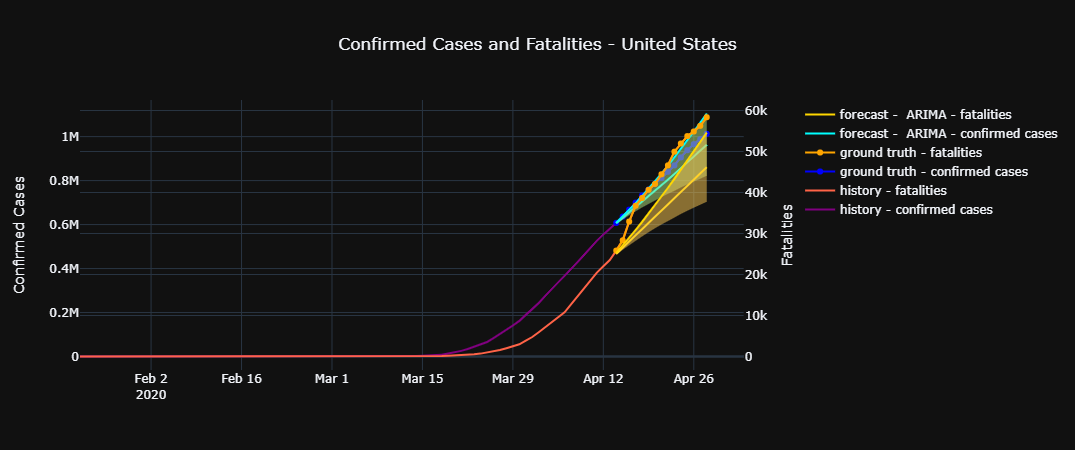

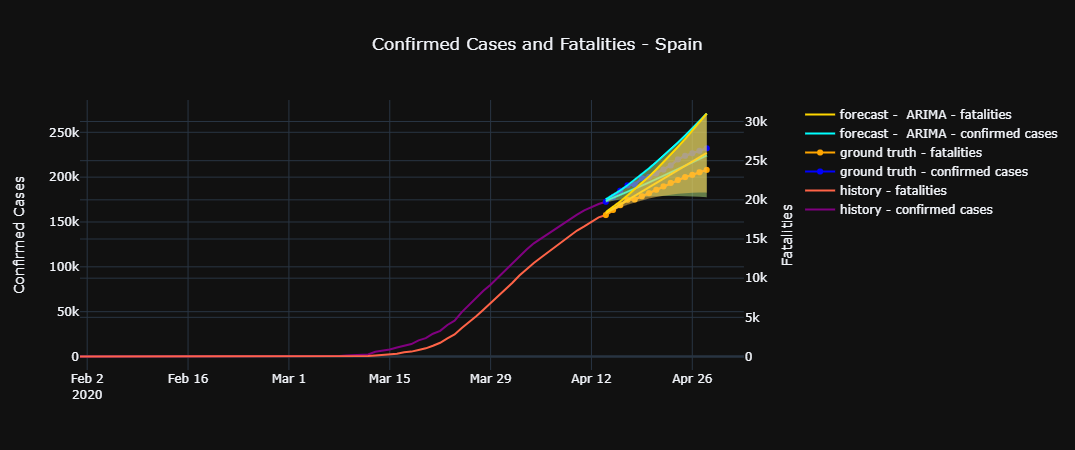

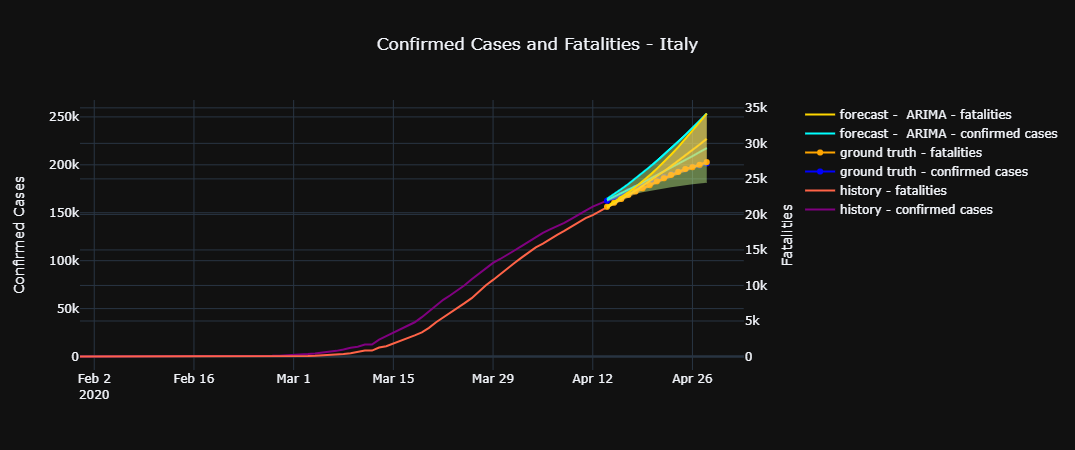

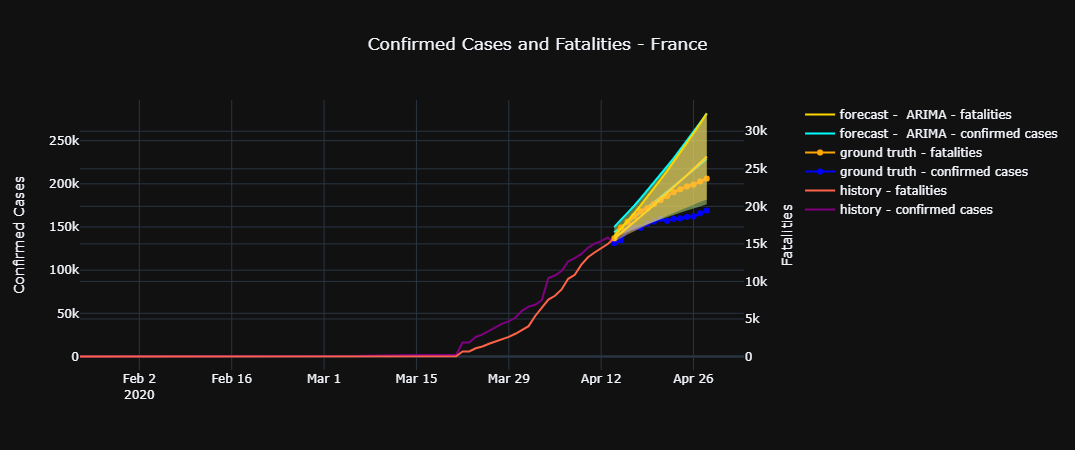

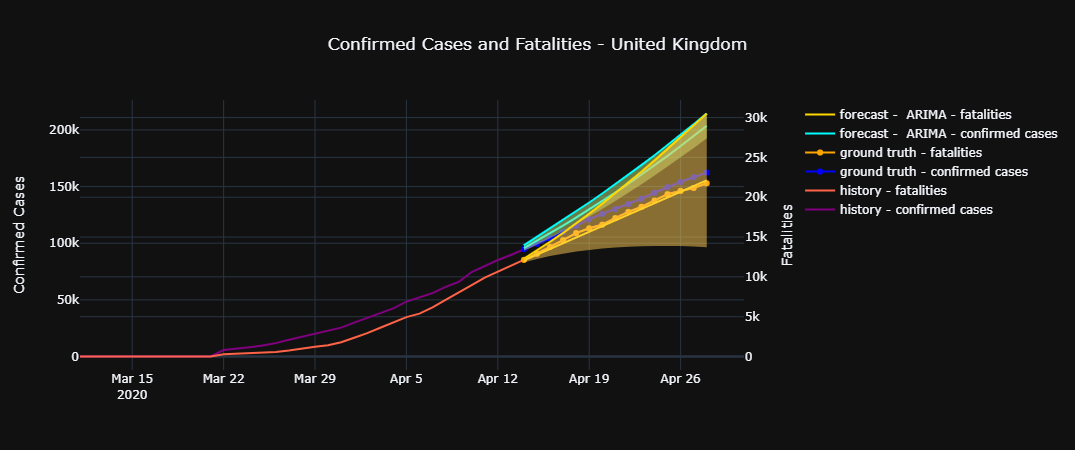

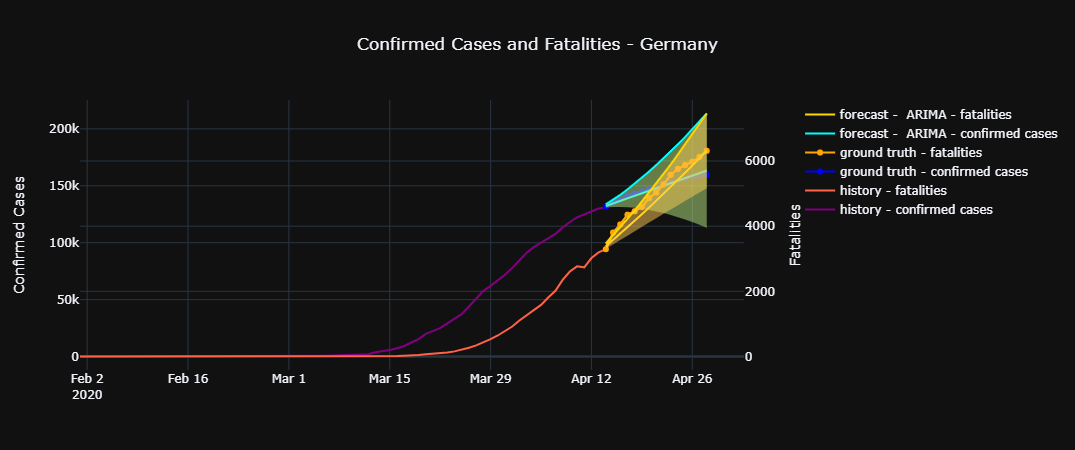

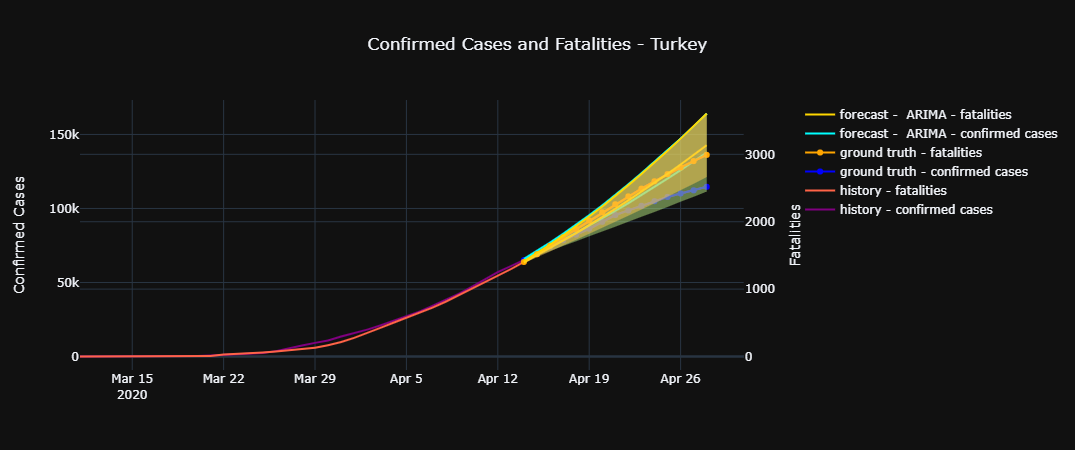

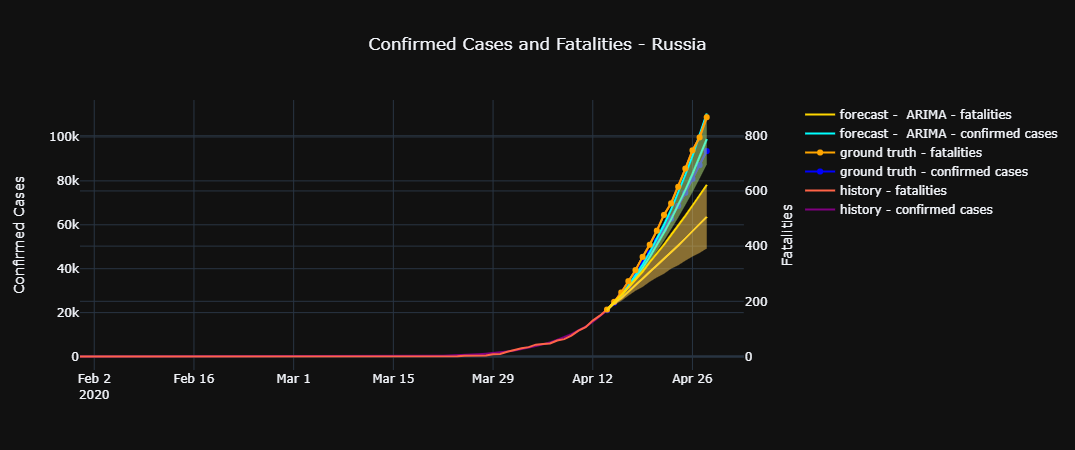

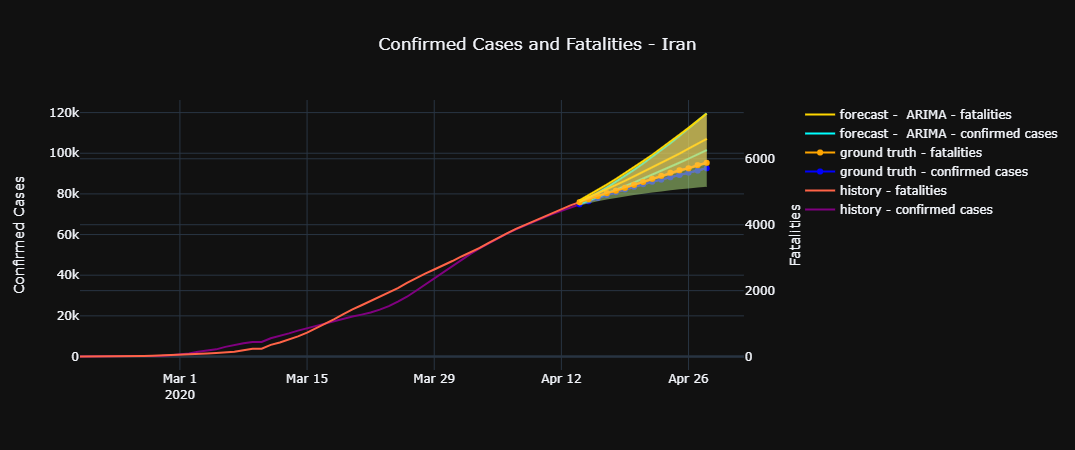

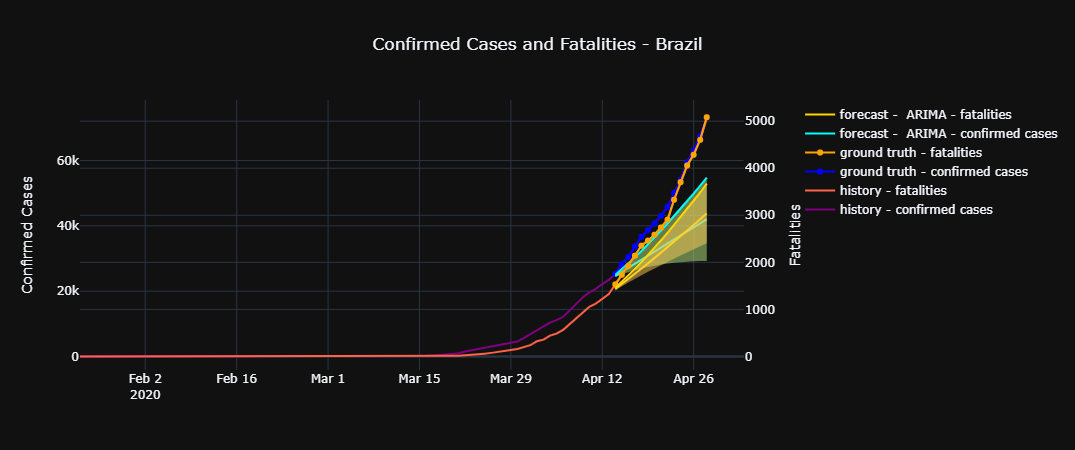

In [120]:
for country in topCountriesConfCases:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    info_train = df[(df['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_train['date'], y=info_train['confirmed'], name='history - confirmed cases', line=dict(color='purple')))
    fig.add_trace(go.Scatter(x=info_train['date'], y=info_train['deaths'], name='history - fatalities', line=dict(color='tomato')), secondary_y=True)
    info_val = val[(val['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_val['date'], y=info_val['confirmed'], name='ground truth - confirmed cases', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=info_val['date'], y=info_val['deaths'], name='ground truth - fatalities', line=dict(color='orange')), secondary_y=True)
    
    info_pred = y_arima[(y_arima['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred['confirmed'], name='forecast -  ARIMA - confirmed cases', line=dict(color='cyan'), mode='lines'))
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred['deaths'], name='forecast -  ARIMA - fatalities', line=dict(color='gold'), mode='lines'), secondary_y=True)
    info_pred_lower = y_arima_lower[(y_arima_lower['country_region'] == country)]
    info_pred_upper = y_arima_upper[(y_arima_upper['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_upper['confirmed'], name='upper bound - confirmed cases', showlegend=False,  line=dict(color='cyan'), mode='lines'))
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_lower['confirmed'], name='lower bound - confirmed cases', showlegend=False, fill = 'tonexty', line=dict(color='cyan'), mode='none'))

    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_upper['deaths'], name='upper bound - fatalities', showlegend=False, line=dict(color='gold'), mode='lines'), secondary_y=True)
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_lower['deaths'], name='lower bound - fatalities', showlegend=False, fill = 'tonexty', line=dict(color='gold'), mode='none'), secondary_y=True)

    fig.update_yaxes(title_text="Confirmed Cases", secondary_y=False)
    fig.update_yaxes(title_text="Fatalities", secondary_y=True)
    fig.update_layout(title_text='Confirmed Cases and Fatalities - {}'.format(country), title_x=0.5)

    fig.show()

<b> On average, the results are satisfying. However, it's not able yet to forecast when the number of cases will stabilize. Forecasting is not good for countries with few data or with only constant time series. 
Results can be improved by adding exogenous variables like temperature </b>

## Auto ARIMA - full history

In [71]:
dict_order_cc = {}
dict_order_ft = {}

In [72]:
dates_forecast = pd.date_range(max(df['date']) + timedelta(days=1), max(df['date']) + timedelta(days=Ndays_forecast_val))

In [73]:
y_arima_full = pd.DataFrame(columns=df.columns)
y_arima_full_lower = pd.DataFrame(columns=df.columns)
y_arima_full_upper = pd.DataFrame(columns=df.columns)

In [74]:
for country in tqdm(df['country_region'].unique()):
    arima_model_cc = auto_arima(df.loc[(df['country_region'] == country),'confirmed'].values,
                     start_p=0, start_q=0, start_d=0, max_p=10, max_q=3, max_d=3,
                     start_P=0, start_Q=0, start_D=0, max_P=10, max_Q=3, max_D=3,
                                seasonal=False, trace=False, error_action='ignore', stepwise=True, suppress_warnings=True)
    dict_order_cc['{}'.format(country)] = arima_model_cc.order
    preds_cc, conf_int_cc = arima_model_cc.predict(n_periods=Ndays_forecast_val, return_conf_int=True)

    res_df = pd.DataFrame(columns=df.columns)
    res_df['date'] = dates_forecast
    res_df['country_region'] = country
    res_df['confirmed'] = preds_cc

    res_l_df = pd.DataFrame(columns=df.columns)
    res_l_df['date'] = dates_forecast
    res_l_df['country_region'] = country
    res_l_df['confirmed'] = conf_int_cc[:,0]

    res_u_df = pd.DataFrame(columns=df.columns)#, index=dates_forecast)
    res_u_df['date'] = dates_forecast
    res_u_df['country_region'] = country
    res_u_df['confirmed'] = conf_int_cc[:,1]

    arima_model_ft = auto_arima(df.loc[(df['country_region'] == country),'deaths'].values,
                     start_p=0, start_q=0, start_d=0, max_p=10, max_q=3, max_d=3,
                     start_P=0, start_Q=0, start_D=0, max_P=10, max_Q=3, max_D=3,
                     seasonal=False, trace=False, error_action='ignore', stepwise=True, suppress_warnings=True)
    dict_order_ft['{}'.format(country)] = arima_model_ft.order
    preds_ft, conf_int_ft = arima_model_ft.predict(n_periods=Ndays_forecast_val, return_conf_int=True)

    res_df['deaths'] = preds_ft
    res_l_df['deaths'] = conf_int_ft[:,0]
    res_u_df['deaths'] = conf_int_ft[:,1]

    y_arima_full = pd.concat([y_arima_full,res_df])
    y_arima_full_lower = pd.concat([y_arima_full_lower,res_l_df])
    y_arima_full_upper = pd.concat([y_arima_full_upper,res_u_df])

 10%|████████▍                                                                        | 19/183 [00:58<06:33,  2.40s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 16%|█████████████▎                                                                   | 30/183 [01:31<07:23,  2.90s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 18%|██████████████▌                                                                  | 33/183 [01:44<09:33,  3.82s/it]C:\Users\fatma\anaconda3\envs\ML\lib\site-packages\pmdarima\arima\auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

 26%|█████████████████████▏                                                           | 48/183 [02:16<06:07,  2.72s/it]C:\Users\fatma\anaconda3\envs\ML

In [75]:
y_arima_full.loc[y_arima_full['confirmed'] < 0,'confirmed'] = 0
y_arima_full_lower.loc[y_arima_full_lower['confirmed'] < 0,'confirmed'] = 0
y_arima_full_upper.loc[y_arima_full_upper['confirmed'] < 0,'confirmed'] = 0

In [76]:
y_arima_full['confirmed'] = np.ceil(y_arima_full['confirmed'])
y_arima_full_lower['confirmed'] = np.ceil(y_arima_full_lower['confirmed'])
y_arima_full_upper['confirmed'] = np.ceil(y_arima_full_upper['confirmed'])

In [77]:
y_arima_full.loc[y_arima_full['confirmed'] < 0,'deaths'] = 0
y_arima_full_lower.loc[y_arima_full_lower['confirmed'] < 0,'deaths'] = 0
y_arima_full_upper.loc[y_arima_full_upper['confirmed'] < 0,'deaths'] = 0

In [78]:
y_arima_full['deaths'] = np.ceil(y_arima_full['deaths'])
y_arima_full_lower['deaths'] = np.ceil(y_arima_full_lower['deaths'])
y_arima_full_upper['deaths'] = np.ceil(y_arima_full_upper['deaths'])

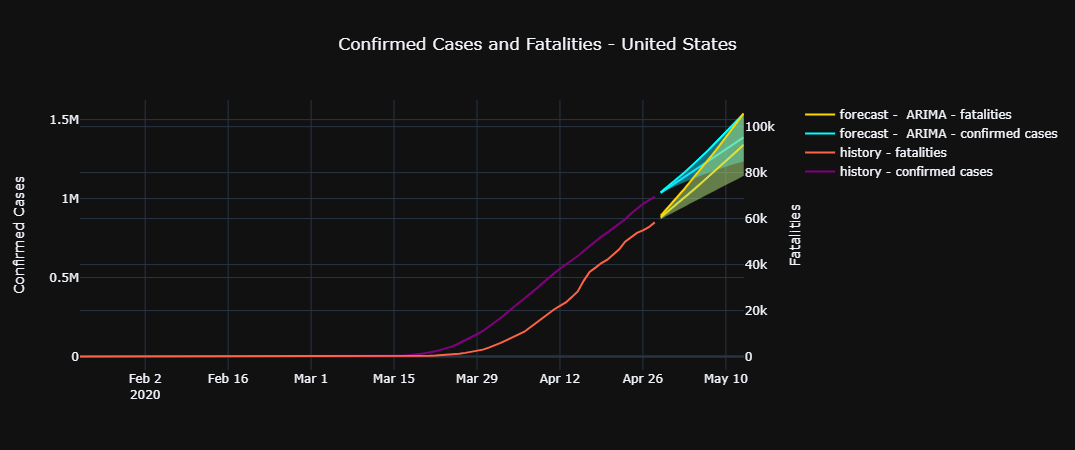

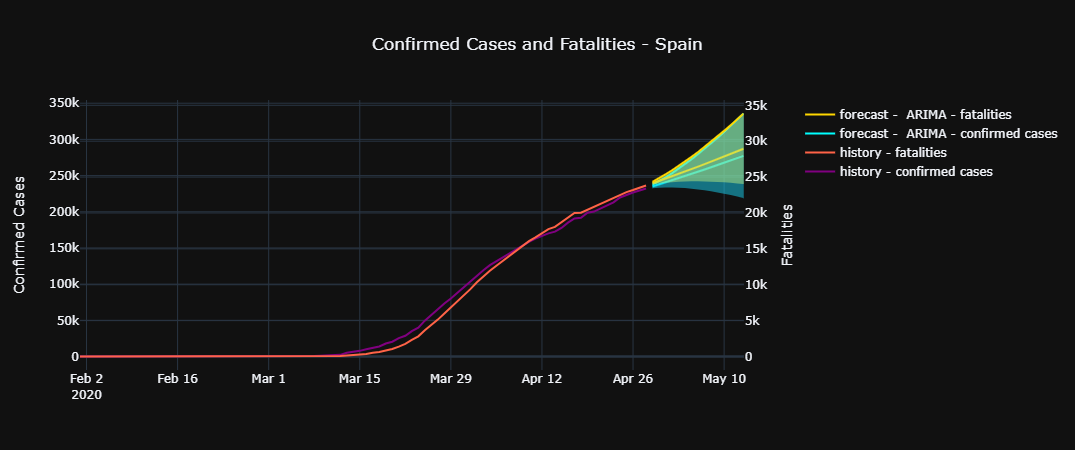

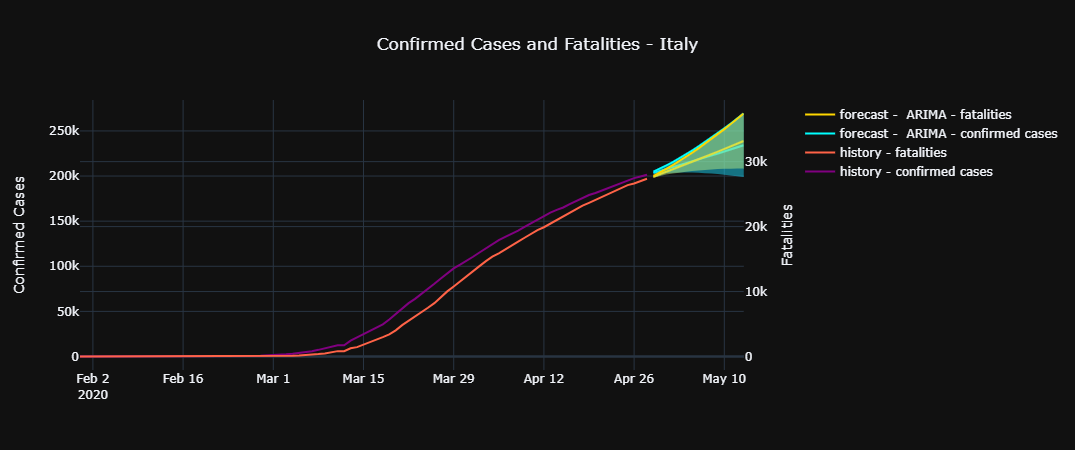

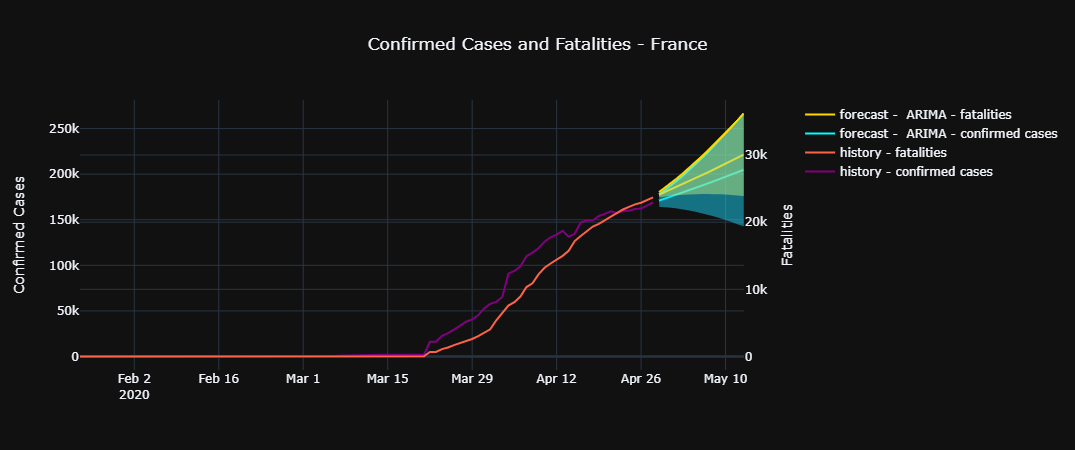

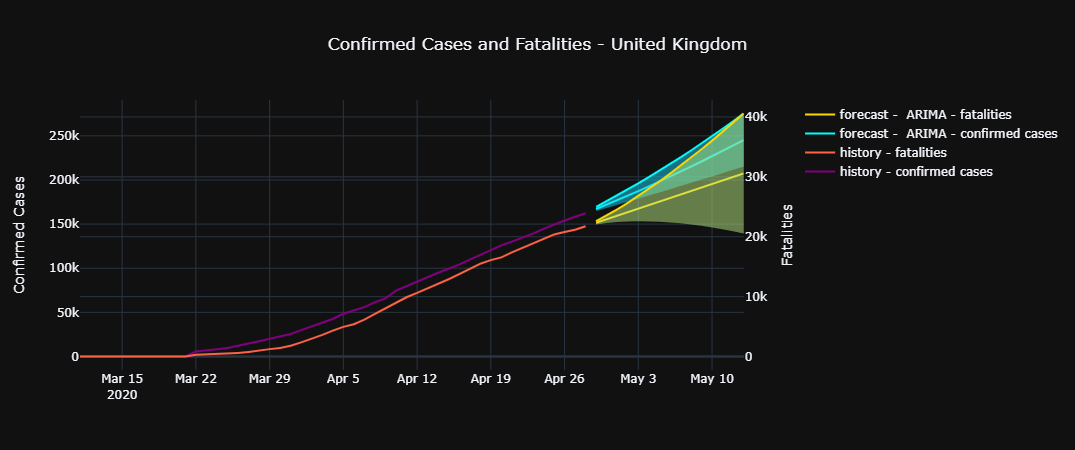

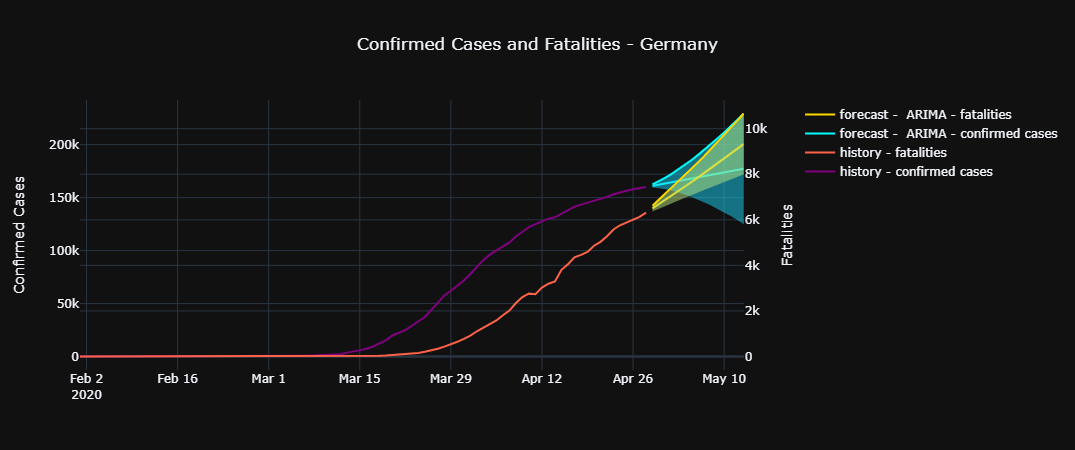

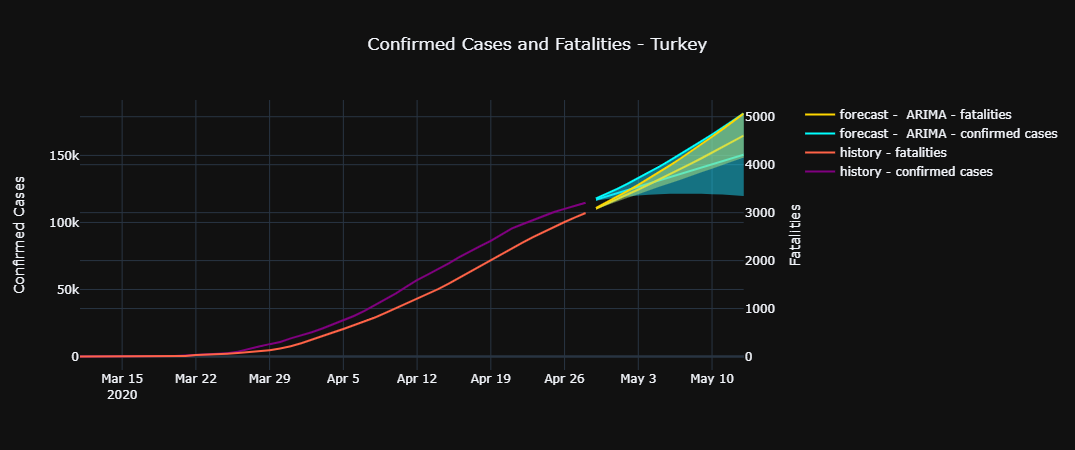

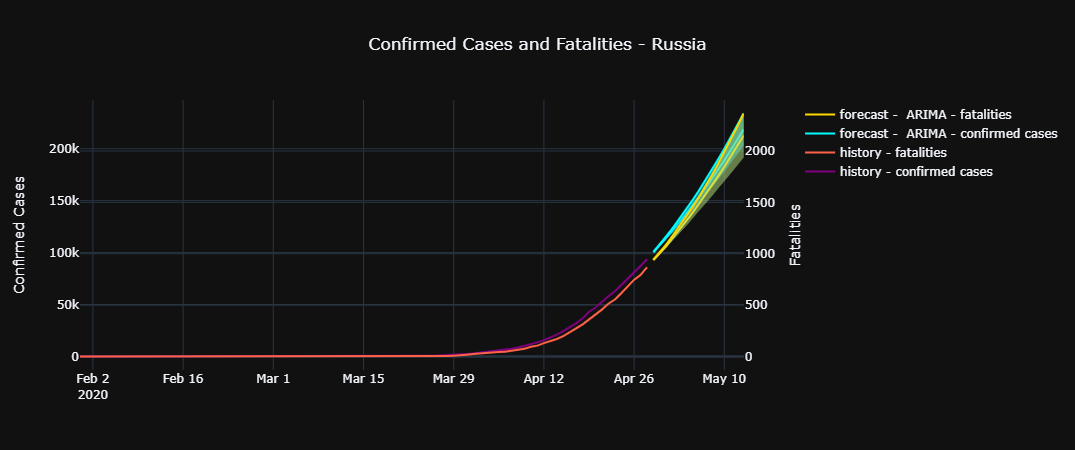

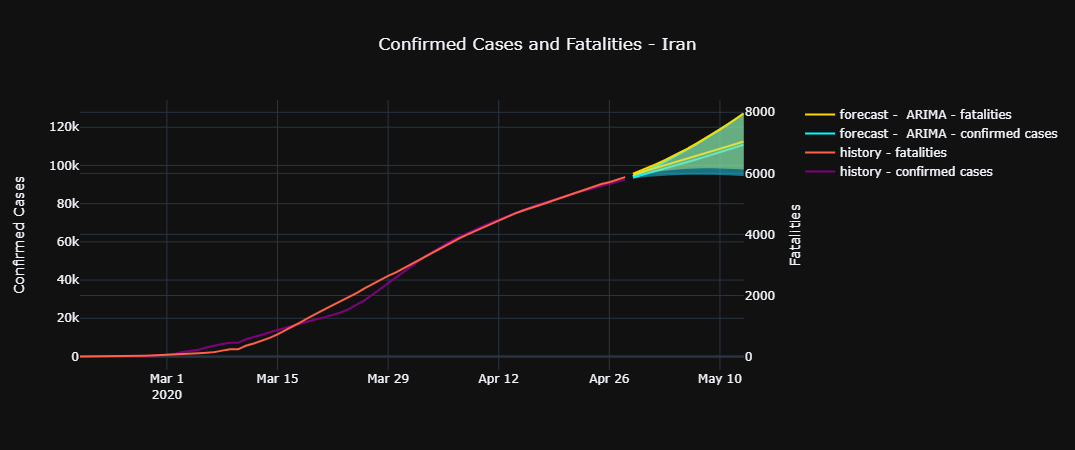

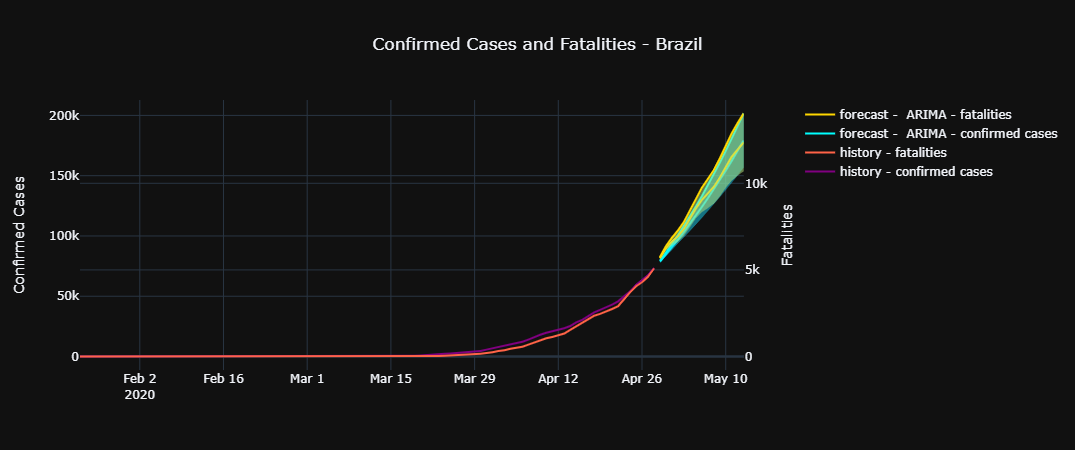

In [111]:
for country in topCountriesConfCases:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    info_df = df[(df['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_df['date'], y=info_df['confirmed'], name='history - confirmed cases', line=dict(color='purple')))
    fig.add_trace(go.Scatter(x=info_df['date'], y=info_df['deaths'], name='history - fatalities', line=dict(color='tomato')), secondary_y=True)
    info_pred = y_arima_full[(y_arima_full['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred['confirmed'], name='forecast -  ARIMA - confirmed cases', line=dict(color='cyan'), mode='lines'))
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred['deaths'], name='forecast -  ARIMA - fatalities', line=dict(color='gold'), mode='lines'), secondary_y=True)
    info_pred_lower = y_arima_full_lower[(y_arima_full_lower['country_region'] == country)]
    info_pred_upper = y_arima_full_upper[(y_arima_full_upper['country_region'] == country)]
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_upper['confirmed'], name='upper bound - confirmed cases', showlegend=False,  line=dict(color='cyan'), mode='lines'))
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_lower['confirmed'], name='lower bound - confirmed cases', showlegend=False, fill = 'tonexty', line=dict(color='cyan'), mode='none'))

    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_upper['deaths'], name='upper bound - fatalities', showlegend=False, line=dict(color='gold'), mode='lines'), secondary_y=True)
    fig.add_trace(go.Scatter(x=info_pred['date'], y=info_pred_lower['deaths'], name='lower bound - fatalities', showlegend=False, fill = 'tonexty', line=dict(color='gold'), mode='none'), secondary_y=True)

    fig.update_yaxes(title_text="Confirmed Cases", secondary_y=False)
    fig.update_yaxes(title_text="Fatalities", secondary_y=True)
    fig.update_layout(title_text='Confirmed Cases and Fatalities - {}'.format(country), title_x=0.5)

    fig.show()